<a href="https://colab.research.google.com/github/ShikaiKevinLiu/Study/blob/main/report_notebook_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Job Salaries from Indeed.ca
**STA 2453 Project 1  
Tuesday, December 15, 2020  
By: Brendan, Kexin, Cheng, Shikai**

This project investigates the task of predicting jobs salaries from job advertisements collected from indeed.ca. Our two goals are 1: Create a model capable of predicting job salary and 2: Investigate which features are important to predicting job salary.

This notebook assumes that the web scraping has been performed by our web scraping scripts. We began with exploratory analysis of our scraped data, looking at distributions of the variables and then proceeded to use NLP techniques to create word features for the text data. Next, we created bag-of-words models using both our text and numerical features. To achieve our two goals we focused on interpretable models or models where we can estimate feature importance. To finish we analyzed the results. Our top logistic regression model achieved an F1 score of 0.654519. Looking at the feature importances we see that job categories and locations are the most important. After that education and key technology skills are the most important.

## Introduction

If you are looking for a job it is very common to apply on a job board. Unfortunately, many job advertisers do not have the job salary information on the job ad. You want to know what you will make before you spend a large quantity of time going through through the application process and interviews. You also may want to know which factors lead to higher or lower salaries. 

We have decided to investgigate two questions. Can we predict job salary based on a job advertisement? And, are there any potential features that can determine higher or lower paying salaries?

If we knew the answers to these questions we could make our job search more efficient and tailor our resume to maximize our potential salary.

We began by scraping our data from indeed.ca. Below is a short exploratory analysis of that data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")
from clean_data import *
nltk.download('stopwords')
import os
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

Mounted at /content/drive


ModuleNotFoundError: ignored

# Exploratory Data Analysis

Before building the model to explore the relation between salaries and the data features, we performed an explortory analysis of the data. We aimed to understand more about the characteristics and distributions of the variables that we had scraped.

After scraping the data, we obtained 950 samples. Firstly, we noted that the salaries are in different forms, some are based on hour/year, and some are in a range such as 70-80 an hour, etc. To account for this we converted all salaries to be measured in terms of dollars per year.

In [ ]:
job_salary = pd.read_csv("data.csv")
job_salary.salary

0      $36.45 - $43.04 an hour
1                  $43 an hour
2                  $28 an hour
3                  $46 an hour
4               $34.50 an hour
                ...           
945          $70 - $80 an hour
946            $120,000 a year
947             $40.35 an hour
948             $40.10 an hour
949                $35 an hour
Name: salary, Length: 950, dtype: object

In [ ]:
job_salary = pd.read_csv("data.csv")
job_salary_cleaned = clean_requirements(job_salary)
job_salary_cleaned = convert_salary(job_salary)
job_salary_cleaned.salary

0      100157.4
1      108360.0
2       70560.0
3      115920.0
4       86940.0
         ...   
945    189000.0
946    120000.0
947    101682.0
948    101052.0
949     88200.0
Name: salary, Length: 950, dtype: float64

## Distribution of the salary



 We observed that most salaries are between 50,000 to 100,000 which makes sense.

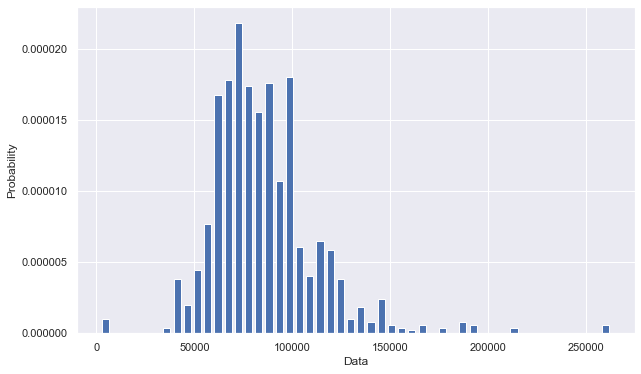

In [ ]:
salary = job_salary_cleaned.salary.tolist()
plt.figure(figsize=(10,6))
plt.hist(salary,density=True, bins=50,rwidth=0.7)
plt.ylabel('Probability')
plt.xlabel('Data') 
plt.show()

Next, We split the salaries into five ranges: <50K, 50-75K, 75-100K, 100-150K, >150K.

In [ ]:
# divide salary into 5 buckets
def salary_bucket(salary):
    if salary < 50000:
        return '<50,000'
    if salary >= 50000 and salary < 75000:
        return '50,000-75,000'
    elif salary >= 75000 and salary < 100000:
        return '75,000-100,000'
    elif salary >=100000 and salary <= 150000:
        return '100,000-150,000'
    else:
        return '>150,000'
    
job_salary_cleaned['salary_buckets'] = job_salary_cleaned['salary'].apply(lambda x: salary_bucket(x))

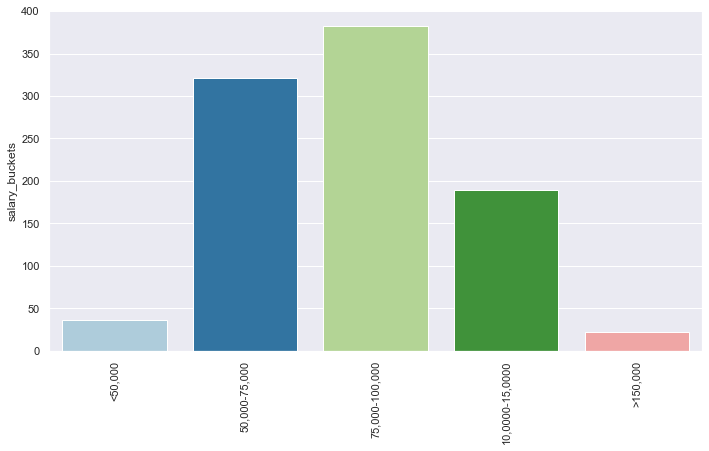

In [ ]:
buckets_count = job_salary_cleaned['salary_buckets'].value_counts()
# distribution of classes
# [3, 1, 0, 2, 4] is used to list classes in ascending order
sns.set(rc={'figure.figsize':(11.7,6.27)}) 
sns.barplot(x=buckets_count.index[[3,1,0,2,4]], y=buckets_count[[3,1,0,2,4]], palette="Paired")
plt.xticks(rotation=90)
plt.show()

### Location feature

For each province and city we calculated the average salaries. We observed that the average salary is different in each province. ON and BC were the provinces with the highest average salary. Remote jobs had the highest average salary overall.

However, there is not a large variance between the average salaries of different provinces. Instead, we looked at the average salary on each city. The differences became more pronounced with some cities having an average salary higher than 100,000 and some lower than 60,000.




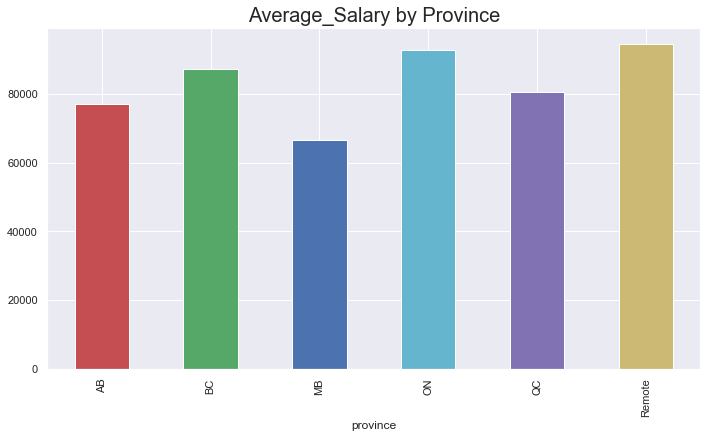

In [ ]:
data = job_salary_cleaned
data = clean_location(data)
my_colors = 'rgbcmyk' 
mean_salary = data.groupby(['province']).mean()
mean_salary.plot(kind='bar',color=my_colors,legend=False)
plt.title("Average_Salary by Province", fontsize =20)
plt.show()

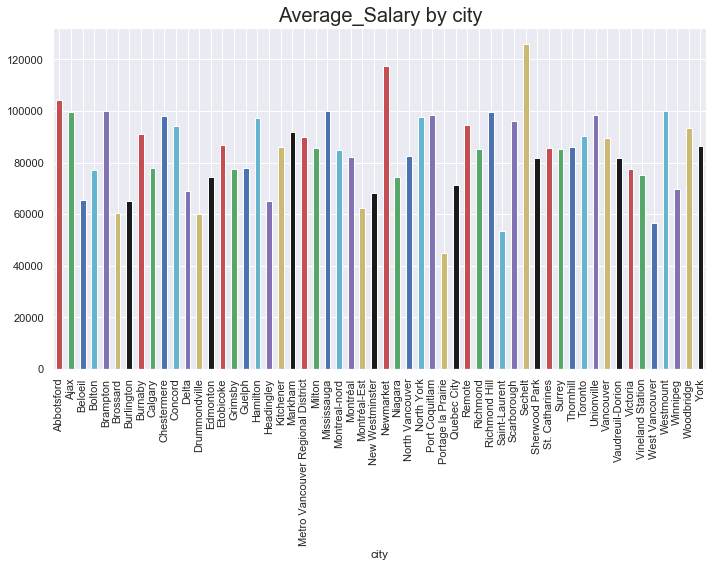

In [ ]:
mean_salary = data.groupby(['city']).mean()
mean_salary.plot(kind='bar',color=my_colors,legend=False)
plt.title("Average_Salary by city", fontsize =20)
plt.show()

### Job requirements feature



In order to extract features from requirement text, we needed nature language processing (NLP) method to handle with text data. Term frequency-inverse document frequency (TF-IDF) is one of the popular NLP methods, which can reflect how important a word is to a document in a corpus. Compared to bag of words, another popular NLP method, TF-IDF reduces the importance of some frequently occurring terms like we, need or have which may not be included in stop words. If a term appears in every observation, it has no contribution to the model. Thus, we decided to use TF-IDF to extract features. In python, the sklearn library has a function called TFidfVectorizer. It can calculate a TF-IDF vector for each document. Because some bigrams like machine learning or deep learning may be important to predict the salary, we extracted both unigrams and bigrams at the same time, and we only selected top 1,000 features. If we included all features, the dimensionality would be too large for our small number of observations. 

The following two images show the top 50 words in the selected features. 

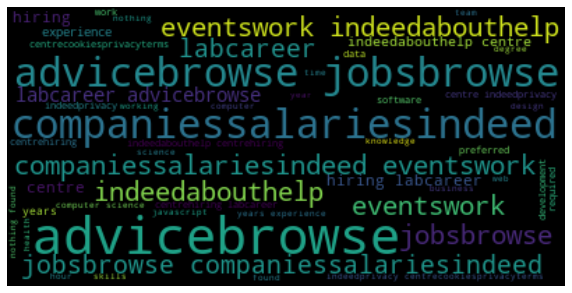

In [ ]:
# extract features
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
corpus = data['requirements_cleaned'].values
grams = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
words_df = pd.DataFrame(grams.toarray(), columns=feature_names)

amount = words_df.sum(axis=0)
top50 = amount.nlargest(50)
df = top50.to_frame().reset_index()
df.columns = ['word', 'count']
words = dict(zip(df['word'].tolist(), df['count'].tolist()))

wc = WordCloud().generate_from_frequencies(words)

plt.figure(figsize=(10, 10))
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

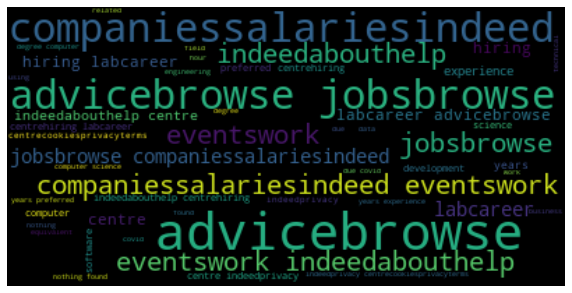

In [ ]:
high_salary = data.loc[data['salary'] >100000]
# extract features
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
corpus = high_salary['requirements_cleaned'].values
grams = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
words_df = pd.DataFrame(grams.toarray(), columns=feature_names)

amount = words_df.sum(axis=0)
top50 = amount.nlargest(50)
df = top50.to_frame().reset_index()
df.columns = ['word', 'count']
words = dict(zip(df['word'].tolist(), df['count'].tolist()))
wc = WordCloud().generate_from_frequencies(words)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

The selected words are similar despite whther salary constraints were added or not. Words like advicebrowse, companiessalariesindeed, eventswork had large overall TF-IDF values in the corpus but they don’t make any sense for job hunters. It seemed as though the relative frequency of words was not especially useful on its own. We decided to build models to further explore the relationship between word usage and salary. 

### Category feature
In the web scraping step, we crawled salaries for 5 different job categories related to software and development.

In [ ]:
category = pd.DataFrame(job_salary['job_category'].value_counts()).reset_index()
category.columns = ['category', 'amount']
cat = category['category'] ; amount = category['amount']
colors = 'yrbkc' 

explode = (0, 0, 0, 0, 0)  
wedges, texts = plt.pie(amount, colors = colors, startangle=90, explode=explode)
plt.axis('equal') 
plt.legend(wedges, cat, loc="best")
plt.show()


NameError: name 'pd' is not defined

Since there were not many examples of jobs such as data scientist and data engineer, it may not very useful to compare the mean salary of different categories. From the scatter plots, we observed that most jobs in each catagory had a similar salary range.

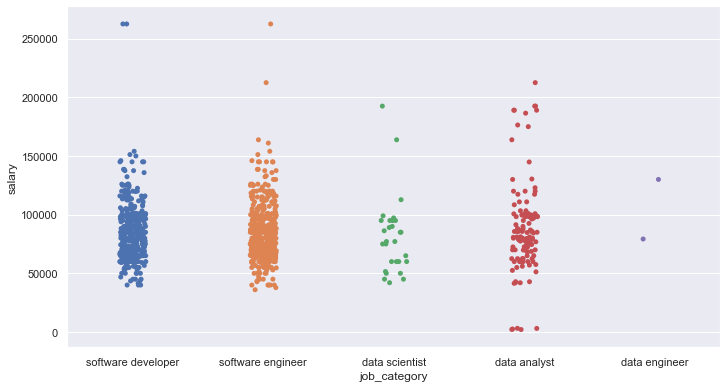

In [ ]:
sns.stripplot(x="job_category", y="salary", data=job_salary_cleaned) 
plt.show()

# Model Selection

In the project, we implemented logistic regression, K nearest neighbor (KNN), and random forest model. In the 2019 Kaggle ML and Data Science Survey these three models were ranked among the most popular used for classification. The first model, logistic regression, is commonly used as a baseline in classification tasks. Thus we decided to use it as one of the models to predict salary from the job advertisement features. We also used random forest which is a tree ensemble method. Random orest uses a bootstrap method to build the trees which may reduce the impact of our unbalanced data. Additionally, random forest has the additional benefit of computing the importance of features so we may better udnerstand which skills are most important to predicting job salary.We also tried KNN as it is a very interpretable classification model.

In order to make sure the final model is generalized, we split the dataset into training set and test set using an 80:20 ratio. For the evaluation metric, we chose weighted F1 score because the target has 5 imbalanced classes. he weighted F1 score takes into account the class imblanaces. Additionally, we used a grid search and cross validation to tune the hyperparameters. Initially, we used job category, location and 1000 extracted features to build the models. 

### Models including job_category and location

In [ ]:
# drop useless columns
full_data = clean_location(job_salary_cleaned)
mod_data = full_data.drop(columns=['job_title', 'company_name', 'requirements', 'industry', 'requirements_cleaned'])
mod_data = pd.get_dummies(data=mod_data, columns=['job_category','city', 'province'])
mod_data =mod_data.drop(columns=['salary', 'salary_buckets'])

In [ ]:
# extract features using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
corpus = full_data['requirements_cleaned'].values
grams = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
words_df = pd.DataFrame(grams.toarray(), columns=feature_names)

In [ ]:
# split the data
X = pd.concat([mod_data, words_df], axis=1)
Y = full_data['salary_buckets']
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state=20, test_size=0.2)

In [ ]:
# logistic regression
mod_log = LogisticRegression()
c = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20, 100, 200, 500, 1000]
parameters = {'C': c}
metric = make_scorer(f1_score, average='weighted')
grid_log = GridSearchCV(mod_log, parameters, scoring=metric, cv=5)
grid_log = grid_log.fit(xtrain, ytrain)
opt_log = grid_log.best_estimator_
#print("The optimal logistic regression model: \n", opt_log)
#print("====================================================================")
#print("The mean accuracy score is {0}.".format(grid_log.best_score_))

In [ ]:
# KNN
mod_knn = KNeighborsClassifier()
neighbors = np.array(range(5, 50, 5))
parameters = {'n_neighbors': neighbors, 'weights': ['uniform', 'distance']}
metric = make_scorer(f1_score, average='weighted')
grid_knn = GridSearchCV(mod_knn, parameters, scoring=metric, cv=5)
grid_knn = grid_knn.fit(xtrain, ytrain)
opt_knn = grid_knn.best_estimator_
#print("The optimal SVM model: \n", opt_knn)
#print("====================================================================")
#print("The mean accuracy score is {0}.".format(grid_knn.best_score_))

In [ ]:
# random forest
mod_rf = RandomForestClassifier(random_state=44)
numTrees = np.array(range(50, 500, 50))
parameters = {'n_estimators': numTrees}
metric = make_scorer(f1_score, average='weighted')
grid_rf = GridSearchCV(mod_rf, parameters, scoring=metric, cv=5)
grid_rf = grid_rf.fit(xtrain, ytrain)
opt_rf = grid_rf.best_estimator_
#print("The optimal random forest model: \n", opt_rf)
#print("====================================================================")
#print("The mean accuracy score is {0}.".format(grid_rf.best_score_))

In [ ]:
score_df = pd.DataFrame(np.array([grid_log.best_score_, grid_knn.best_score_, grid_rf.best_score_]), 
                        columns=['F1 score'],
                        index=['Logistic Regression', 'KNN', 'Random Forest'])
score_df

,F1 score
Logistic Regression,0.671812
KNN,0.435024
Random Forest,0.646524


In [ ]:
print("The weighted macro f1 score of the optimal logistic regression model is", 
      f1_score(ytest, opt_log.predict(xtest), average='weighted'), ".")

The weighted macro f1 score of the optimal logistic regression model is 0.6791827294591143 .


By comparing their F1 scores, we found that logistic regression model gave the highest score among these three models. On the training set, the score of logistic regression was 67.18%. On the test set, the score of the logistic regression was 67.92%. Its training score and test score are close, indicating no overfitting. 

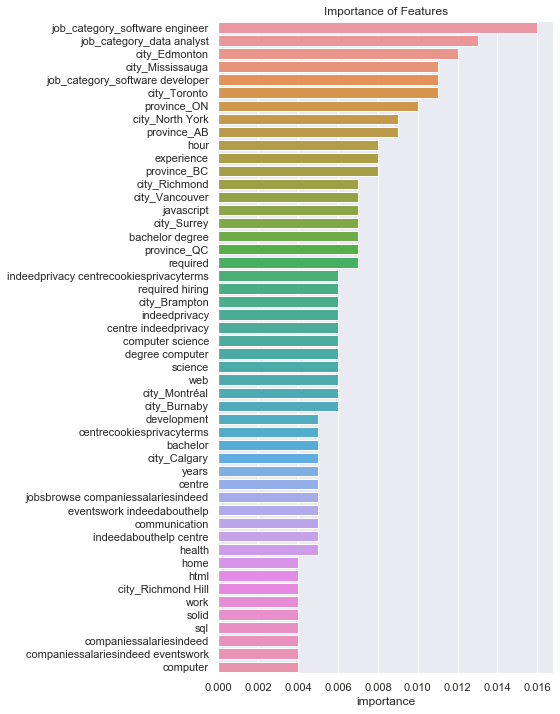

In [ ]:
# visualize feature importance based on TF-IDF
# create feature importance data frame
df = pd.DataFrame(opt_rf.feature_importances_, columns=["importance"],
                  index=X.columns)
# sort by importance
df = df.sort_values('importance', ascending=False)
# plot top 20 features
plt.figure(figsize = (6,12))
sns.barplot(x=np.round(df.importance, 3)[0:50], y=df.index[0:50])
plt.title("Importance of Features")
plt.show()

However, when we looked the feature importance, we found the most top important features are job categories and locations, which make sense because the salary must be influenced by them. However, the aim of the project is to find which skills are important for job hunters. In this case, we decided to exclude job category and location when we fitted models.

### Model selection excluding job_category and location

In [ ]:
# when job_category and location are excluded
mod_data = full_data.drop(columns=['job_title', 'company_name', 'requirements', 'industry', 'requirements_cleaned'])
mod_data = mod_data.drop(columns=['job_category', 'city', 'province'])
mod_data =mod_data.drop(columns=['salary', 'salary_buckets'])

In [ ]:
# split the data
X = pd.concat([mod_data, words_df], axis=1)
Y = full_data['salary_buckets']
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state=20, test_size=0.2)

In [ ]:
# logistic regression
mod_log = LogisticRegression()
c = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20, 100, 200, 500, 1000]
parameters = {'C': c}
metric = make_scorer(f1_score, average='weighted')
grid_log = GridSearchCV(mod_log, parameters, scoring=metric, cv=5)
grid_log = grid_log.fit(xtrain, ytrain)
opt_log = grid_log.best_estimator_
#print("The optimal logistic regression model: \n", opt_log)
#print("====================================================================")
#print("The mean accuracy score is {0}.".format(grid_log.best_score_))

In [ ]:
# KNN
mod_knn = KNeighborsClassifier()
neighbors = np.array(range(5, 50, 5))
parameters = {'n_neighbors': neighbors, 'weights': ['uniform', 'distance']}
metric = make_scorer(f1_score, average='weighted')
grid_knn = GridSearchCV(mod_knn, parameters, scoring=metric, cv=5)
grid_knn = grid_knn.fit(xtrain, ytrain)
opt_knn = grid_knn.best_estimator_
#print("The optimal SVM model: \n", opt_knn)
#print("====================================================================")
#print("The mean accuracy score is {0}.".format(grid_knn.best_score_))

In [ ]:
# random forest
mod_rf = RandomForestClassifier(random_state=44)
numTrees = np.array(range(50, 500, 50))
parameters = {'n_estimators': numTrees}
metric = make_scorer(f1_score, average='weighted')
grid_rf = GridSearchCV(mod_rf, parameters, scoring=metric, cv=5)
grid_rf = grid_rf.fit(xtrain, ytrain)
opt_rf = grid_rf.best_estimator_
#print("The optimal random forest model: \n", opt_rf)
#print("====================================================================")
#print("The mean accuracy score is {0}.".format(grid_rf.best_score_))

In [ ]:
score_df = pd.DataFrame(np.array([grid_log.best_score_, grid_knn.best_score_, grid_rf.best_score_]), 
                        columns=['F1 score'],
                        index=['Logistic Regression', 'KNN', 'Random Forest'])
score_df

,F1 score
Logistic Regression,0.654519
KNN,0.624966
Random Forest,0.650368


As shown in the table, compared to previous models, the scores of the new models changed but the logistic regression model still gives the highest score on the training set. 

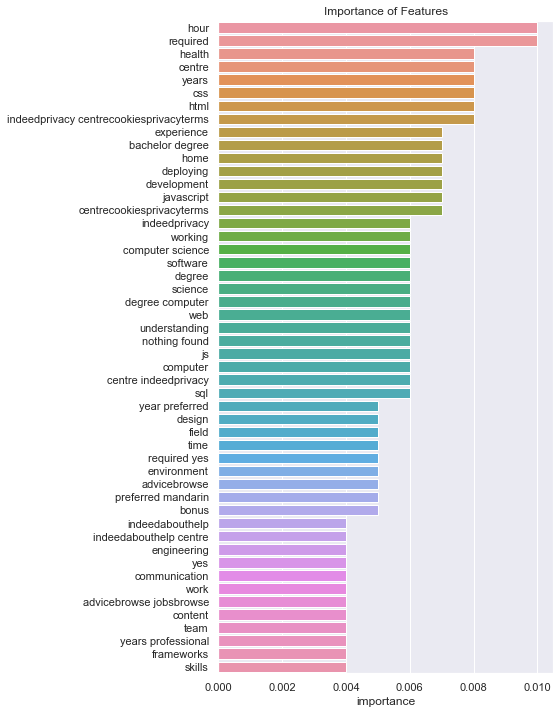

In [ ]:
# visualize feature importance based on bag of wrods
# create feature importance data frame
df = pd.DataFrame(opt_rf.feature_importances_, columns=["importance"],
                  index=X.columns)
# sort by importance
df = df.sort_values('importance', ascending=False)
# plot top 20 features
plt.figure(figsize = (6,12))
sns.barplot(x=np.round(df.importance, 3)[0:50], y=df.index[0:50])
plt.title("Importance of Features")
plt.show()

When we looked the feature importance again, we found the programming language like javascript, html, sql, and css are important. Besides, the degree in computer science has a significant impact on the salary as well. Moreover, the score of the logistic regression model on the test set is 65.34%.

In [ ]:
print("The weighted macro f1 score of the optimal random forest model is", 
      f1_score(ytest, opt_log.predict(xtest), average='weighted'), ".")

The weighted macro f1 score of the optimal random forest model is 0.653350443002876 .


Finally, we checked the coefficients from the final logistic regression model. Particularly for each class of salary we wanted know what were the most influential words that increased the probability of the class these words correspond to the input features for largest positive coefficients. Additionally, we sought to discover the words that decreased the probability of the class which correspond to the words with the most negative coefficients. 

In [ ]:
coef_matrix = opt_log.coef_
# get the index of 10 smallest coefficients 
index_smallest = [list(np.argsort(x)[:10]) for x in coef_matrix]
# get the index of 10 largest coefficients
index_largest = [list(np.argsort(-x)[:10]) for x in coef_matrix]
# create a data frame which contains features with the 10 smallest coefficients
smallest_feature_df = pd.DataFrame([X.columns[x] for x in index_smallest], index=opt_log.classes_)
# create a data frame which contains features with the 10 largest coefficients
largest_feature_df = pd.DataFrame([X.columns[x] for x in index_largest], index=opt_log.classes_)
# create a data frame which contains features' coefficients associated with smallest_feature_df
smallest_coef_df = pd.DataFrame([coef_matrix[x][index_smallest[x]] for x in range(len(index_smallest))], index=opt_log.classes_)
# create a data frame which contains features' coefficients associated with largest_feature_df
largest_coef_df = pd.DataFrame([coef_matrix[x][index_largest[x]] for x in range(len(index_largest))], index=opt_log.classes_)

In [ ]:
smallest_feature_df

,0,1,2,3,4,5,6,7,8,9
"10,0000-15,0000",bonus,agile scrum,scrum,knowledge,casual,design,mysql,js,communication,testing
"50,000-75,000",dental,building,degree computer,facing,year preferred,django,including,ability,must,technology
"75,000-100,000",home,related,etc experience,ability work,developmentexperience,office,technologies,process,business,project
"<50,000",development,engineering,years,hiring,hiring labcareer,information,hour shiftmonday,software,using,writing
">150,000",years preferred,react,health,management,indeedabouthelp centrehiring,centrehiring,centrehiring labcareer,development years,time,shiftmonday


In [ ]:
smallest_coef_df

,0,1,2,3,4,5,6,7,8,9
"10,0000-15,0000",-5.537386,-5.449267,-5.422637,-4.864413,-4.563615,-4.479798,-4.129897,-3.854207,-3.813631,-3.718879
"50,000-75,000",-5.210803,-4.813210,-4.344665,-4.258374,-4.141300,-3.954722,-3.928332,-3.902048,-3.882968,-3.801919
"75,000-100,000",-7.296871,-4.809430,-4.806181,-4.711514,-4.605810,-4.542210,-4.110028,-4.063157,-3.982562,-3.667043
"<50,000",-3.148126,-2.824971,-2.696013,-2.489459,-2.489259,-2.356741,-2.308185,-2.297799,-2.281447,-2.219745
">150,000",-2.948756,-2.190385,-2.110509,-1.958464,-1.717015,-1.717015,-1.717015,-1.673031,-1.624931,-1.618521


Looking at the salary range of 100,000 - 150,000 words such as mysql, js, testing, scrum etc. lower the probability of this class. Looking at the salary range  50,000 - 75,000 words such as django, dental, degree computer lower the probability of this class. Thus, jobs in this range likely will not include dental but may not require a computer science degree. For the salary range of 75,000 - 100,000 words such as home, business, lower the probability of this class. This range must be more technical in nature and likely do not work from home. Looking at the  salaries < 50,000 words such as development, engineering, year, software lower the probability of this class. These low end jobs likely do not require much development experience and the applicant will not do much engineering. Lastly, for the salaries > 150,000 words such as react (a javascript library), development year, managementyear preferred lead to a lower probability of this class. These jobs do not use the react.js library and are not likely to be related to management or require many years of development experience. We hypothesize that these jobs are more director-level in nature rather than production software developers.

In [ ]:
largest_feature_df

,0,1,2,3,4,5,6,7,8,9
"10,0000-15,0000",home,preferably,deploying,cloud,hour,eventsdental,shiftmonday,content,identity,manage
"50,000-75,000",mandarin,web,office,required yes,clients,js,required hiring,mysql,git,experienced
"75,000-100,000",bachelor degree,bachelor,bonus,en,development years,preferred,agile scrum,experience working,travel,date
"<50,000",care,dental,must,editing,comfortable,care hour,hour shift,one,space,record
">150,000",technical,years required,bi,design,year preferred,user,capabilities,computer based,secondary,required


In [ ]:
largest_coef_df

,0,1,2,3,4,5,6,7,8,9
"10,0000-15,0000",6.903310,5.837550,5.292294,5.235495,4.679831,4.647512,4.557057,4.459684,4.416165,4.280178
"50,000-75,000",6.055229,5.514031,5.343124,5.301661,5.229200,5.194673,5.070668,4.897640,4.762430,4.406164
"75,000-100,000",7.032660,5.737761,5.413230,5.318233,4.886511,4.864826,4.857812,4.401871,4.204180,4.171346
"<50,000",5.511651,4.994520,4.983665,4.018811,3.840097,3.767147,3.713515,3.532246,3.455834,3.292877
">150,000",7.389142,5.965936,4.261527,3.829695,3.766348,3.706698,3.603912,3.115978,3.035591,2.810271


Looking at the salary range of 100,000 - 150,000 words such as cloud, deploying manage etc. increase the probability of this class. These are likely to be backend engineers and managers. Looking at the salary range 50,000 - 75,000 words such as web, js, mysql increase the probability of this class. Thus, jobs in this range likely involve web development. For the salary range of 75,000 - 100,000 words such as bachelor degree, development years, agile scrum etc. increase the probability of this class. This range must be more senior and technical in nature with a formal education. Looking at the salaries < 50,000 words such as dental, hour shift, editing etc. increase the probability of this class. These jobs seem to be paid hourly but include dental coverage. Lastly, for the salaries > 150,000 words such as technical, years required, design etc. lead to a higher probability of this class. Again these jobs seem to be technical director level type positions. 

### Conclusion

We completed this project in three main steps:

(1) Web scraping: To collect data, we wrote a web scraping program in python and conducted unit tests to handle various types of information embedded from the indeed website. To make scraping more effecient, we only considered jobs with a salary feature. In total, we scraped six features for each job, including job title, job category, company name, job requirement, location and salary. Our job search conditions include the 8 main cities in Canada and 5 different job titles. After that, we cleaned the messy data and proceeded to the next task.

(2) Data visualization: Besides showing salaries distribution based on job categories and location, we utilized the TF-IDF method to identify popular key words within job requirements. This provided a qualitative understanding of job features.

(3) Model building: The core mission of this project was to predict salary based on job features. We considered three machine learning models as our candidates: logistic regression, KNN and random forest. To make an overall comparison, we tried different input features and tuned the model hyperparameters. The final evaluation showed that logistic regression outperformed other two models and achieved 65.34% on weighted F1 score. Looking at the coefficients for features it was interesting to note that years of experience, bachelor's degrees, and computer science degrees lead to higher probabilities of being in a high salary class whilst web skills like js and react lead to a higher probability of being in a lower salary class.

For future work, we could try scraping more data and testing other models. On the other hand, using domain knowledge to improve our NLP methods such as manually adding critical key words (machine learning, Python, etc..) might be another way to optimize our work.